## Libraries & necessary pre-code

In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

## Data Collection

In [25]:
tickers = ['TSM', 'NVDA', 'AMD', 'INTC', 'ORCL']
start_date = '2024-10-23'
end_date = '2025-10-23'

def get_ticker_data(ticker, start_date, end_date):
    '''
    Collects daily data for a tickers and returns a dataframe of
    it (without multilevel columns)

    :param ticker: String of a ticker (ex: '^GSPC')
    :param: start_date: start date String in format 'YYYY-MM-DD'
    :param: end_date: end date String in format 'YYYY-MM-DD'

    :return: df (pd.Dataframe) of the data for that ticker on YTD data
    '''
    try:
        # Only really need Open & Close to get daily_returns, and don't need Ticker in the data (drop it)
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)[['Open', 'Close']].droplevel(1, axis=1)
    except Exception:
        return f"Data collection failed for {ticker} from {start_date} to {end_date}"

    return data

# Test
# print(get_ticker_data('^GSPC', '2025-01-06', '2025-10-22').droplevel(1, axis=1))

def get_tickers_data(tickers, start_date, end_date):
    '''
    Iterates through a list of tickers and returns a dictionary of dataframes for it.

    :param tickers: list of Strings of tickers ex: '^GSPC', 'TSMC'
    :param: start_date: start date String in format 'YYYY-MM-DD'
    :param: end_date: end date String in format 'YYYY-MM-DD'

    :return: dictionary of DataFrames connected to the ticker
    '''
    ticker_dict = {}
    try:
        for ticker in tickers:
            ticker_dict[ticker] = get_ticker_data(ticker, start_date, end_date)
    except Exception:
        return f"Data collection failed for {tickers} from {start_date} to {end_date}"

    return ticker_dict

data_dict = get_tickers_data(tickers, start_date, end_date)

rolling_start_date =  '2024-9-11'
# 30 trading days back from 10-23

rolling_data_dict = get_tickers_data(tickers, rolling_start_date, end_date)

# Save to csv
for ticker in data_dict:
    data_dict[ticker].to_csv(f'{ticker}_data.csv')

# Test
data_dict

{'TSM': Price             Open       Close
 Date                              
 2024-10-23  194.584991  198.720474
 2024-10-24  196.840728  195.821686
 2024-10-25  198.116987  201.273010
 2024-10-28  197.137525  192.606308
 2024-10-29  192.319398  194.842239
 ...                ...         ...
 2025-10-16  310.929993  299.839996
 2025-10-17  298.399994  295.079987
 2025-10-20  300.000000  297.700012
 2025-10-21  299.000000  294.510010
 2025-10-22  293.000000  288.880005
 
 [250 rows x 2 columns],
 'NVDA': Price             Open       Close
 Date                              
 2024-10-23  141.989282  139.519989
 2024-10-24  140.779637  140.369751
 2024-10-25  140.889594  141.499420
 2024-10-28  142.959021  140.479736
 2024-10-29  140.249772  141.209503
 ...                ...         ...
 2025-10-16  182.229996  181.809998
 2025-10-17  180.179993  183.220001
 2025-10-20  183.130005  182.639999
 2025-10-21  182.789993  181.160004
 2025-10-22  181.139999  180.279999
 
 [250 rows x 2 colum

## Data Cleaning

In [26]:
# Here we want to clean the data so drop the multilevel columns, verify data, ensure no missing data

# First, check data (see if any missing)
# I think this is the only check we need as yFinance has consistent dating data, naming, pricing (don't have to worry about type mismatch or other trivial items)
def handle_nan(ticker_df):
    '''
    Checks whether the number of missing values is > 0, and if so then use dropna() to clean

    :param ticker_df: the ticker's Data in a pd.DataFrame
    :return: the corrected (or unmodified) dataframe
    '''
    # If >, there's missing
    if ticker_df.isnull().sum().any():
        print(f"Missing vals: {ticker_df.isnull().sum().all()}")
        ticker_df = ticker_df.dropna()

    return ticker_df

# Run it for all our stocks
for ticker in data_dict:
    data_dict[ticker] = handle_nan(data_dict[ticker])
    # Didn't print, so that mean's there's no NaNs

## Feature Engineering


In [27]:
# Daily returns
def get_daily_returns(ticker_data):
    '''
    Get daily returns (% delta) for a ticker (given data) Use ticker data including 1d before start date.

    :param ticker_data: Should be a dataframe including the open and close prices for a certajn amount o dates
    :return: a series of returns or an exception if can't parse data
    '''

    try:
        returns = (ticker_data['Close'].pct_change())
    except Exception:
        return "Data has no Close."
    return returns

# Log returns
def get_log_returns(ticker_data):
    '''
    Get daily log returns for a ticker (given data)

    :param ticker_data: Should be a dataframe including the open and close prices for a certajn amount o dates
    :return: a series of log returns or an exception if can't parse data
    '''

    try:
        log_returns = np.log(ticker_data['Close'] / ticker_data['Open'])


    except Exception:
        return "Issue parsing Open/Close data."

    return log_returns

# Rolling vol
def get_rolling_volatility(ticker_data, window_size=30):
    '''
    Get rolling volatility for a ticker (given data).
    We will use a 30d time period rolling. Use ticker data including 30d before start date.

    :param ticker_data: Should be a dataframe including the open and close prices for a certajn amount o dates
    :return: a series of rolling volatilities based on dates or exception if can't parse
    '''
    try:
        returns = get_daily_returns(ticker_data)
        rolling_vol = returns.rolling(window=window_size).std()
    except Exception:
        return "issue parsing data."

    return rolling_vol

# Now, combine into the existing dataframes
for ticker in rolling_data_dict:
    df_with_buffer = rolling_data_dict[ticker]

    daily_returns = get_daily_returns(df_with_buffer)
    log_returns = get_log_returns(df_with_buffer)
    rolling_vol = get_rolling_volatility(df_with_buffer, window_size=30)

    # Slice to Oct 23+
    daily_returns = daily_returns.loc['2024-10-23':]
    log_returns = log_returns.loc['2024-10-23':]
    rolling_vol = rolling_vol.loc['2024-10-23':]

    data_dict[ticker]['Daily_Return'] = daily_returns
    data_dict[ticker]['Log_Return'] = log_returns
    data_dict[ticker]['Rolling_Vol'] = rolling_vol


# Test
data_dict['AMD']

Price,Open,Close,Daily_Return,Log_Return,Rolling_Vol
Date,,,,,
2024-10-23,153.000000,152.910004,-0.007658,-0.000588,0.023138
2024-10-24,154.740005,153.440002,0.003466,-0.008437,0.023123
2024-10-25,155.399994,156.229996,0.018183,0.005327,0.023280
2024-10-28,158.500000,159.919998,0.023619,0.008919,0.023632
2024-10-29,161.100006,166.250000,0.039582,0.031467,0.024516
...,...,...,...,...,...
2025-10-16,236.289993,234.559998,-0.016932,-0.007348,0.055759
2025-10-17,233.259995,233.080002,-0.006310,-0.000772,0.053853
2025-10-20,236.470001,240.559998,0.032092,0.017148,0.053865


## Exploratory Analysis

In [ ]:
# Price series
for ticker in data_dict:
    df = data_dict[ticker]

    fig,ax = plt.subplots(figsize=(12,6))
    ax.plot(df.index, df['Close'])
    ax.set_title(f'1Y Stock Price Series of {ticker}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

In [ ]:
# Returns
for ticker in data_dict:
    df = data_dict[ticker]

    fig,ax = plt.subplots(figsize=(12,6))
    ax.plot(df.index, df['Daily_Return'])
    ax.set_title(f'1Y Daily Returns (%) of {ticker}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Returns (%)')

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

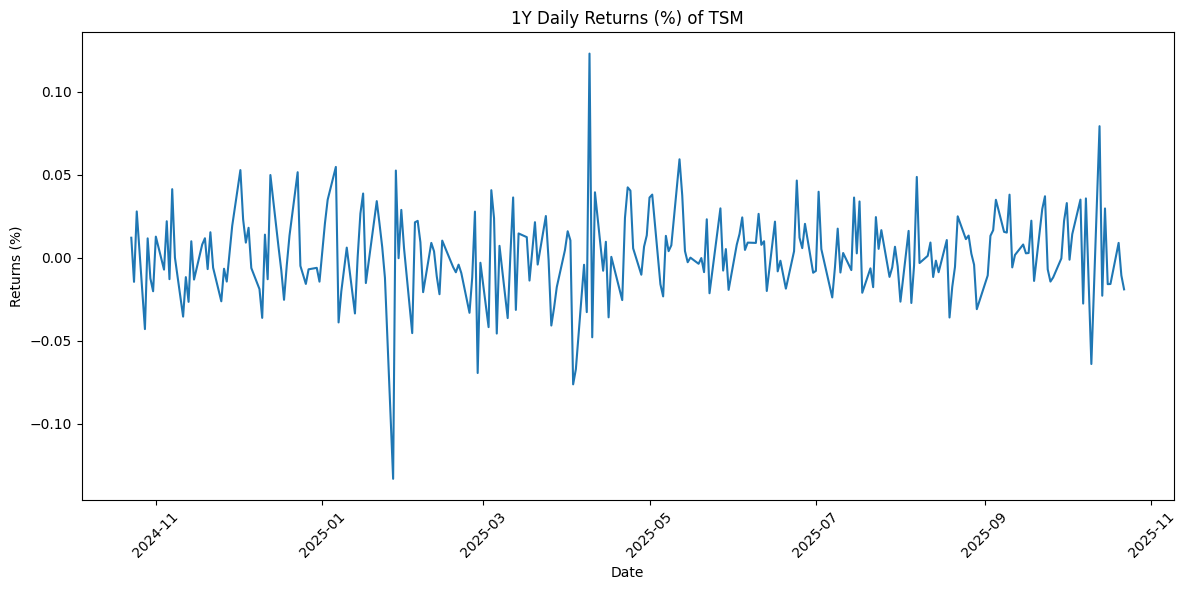

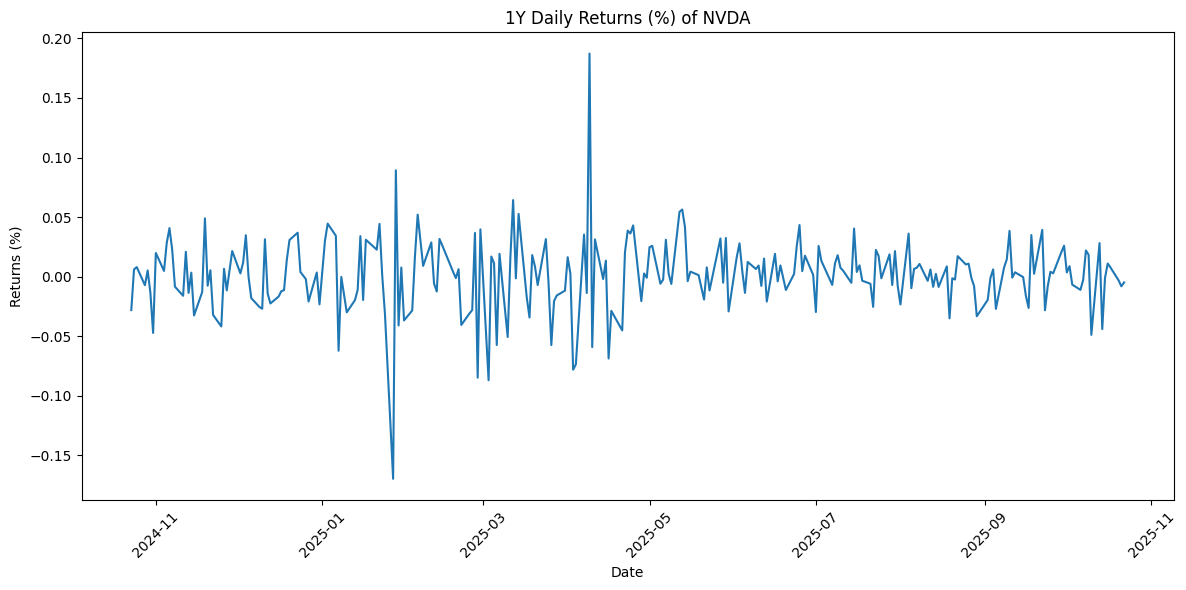

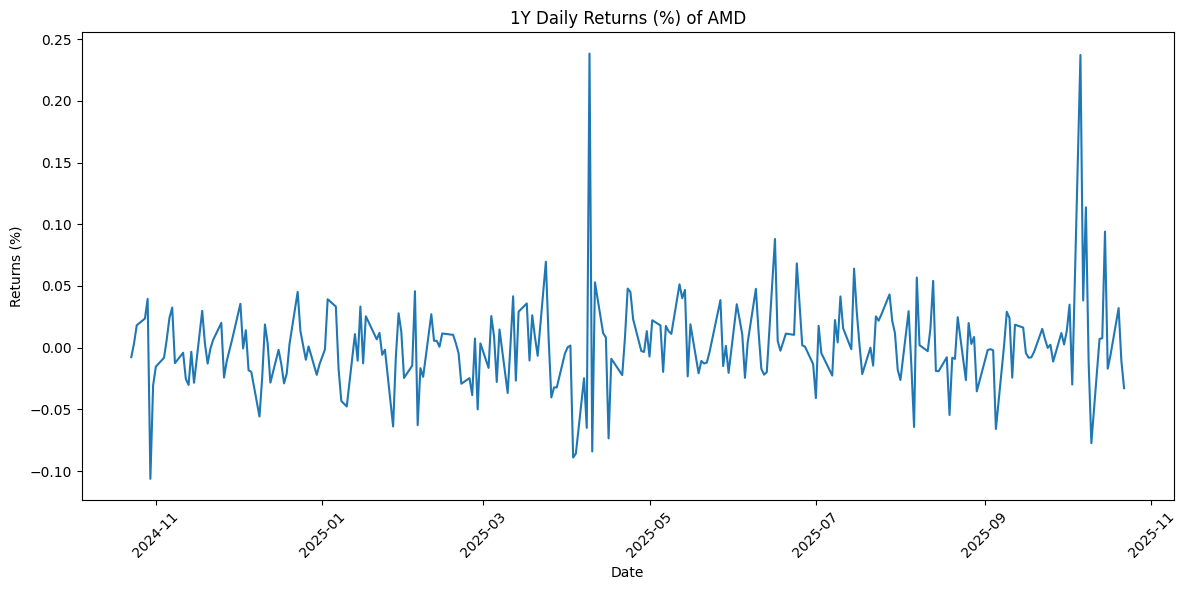

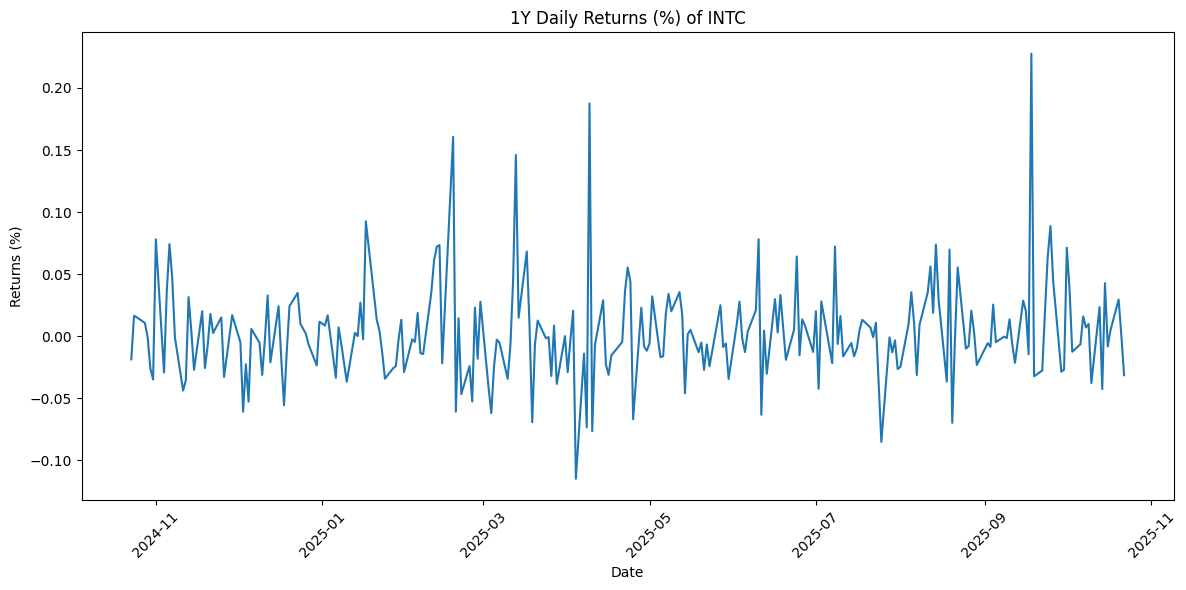

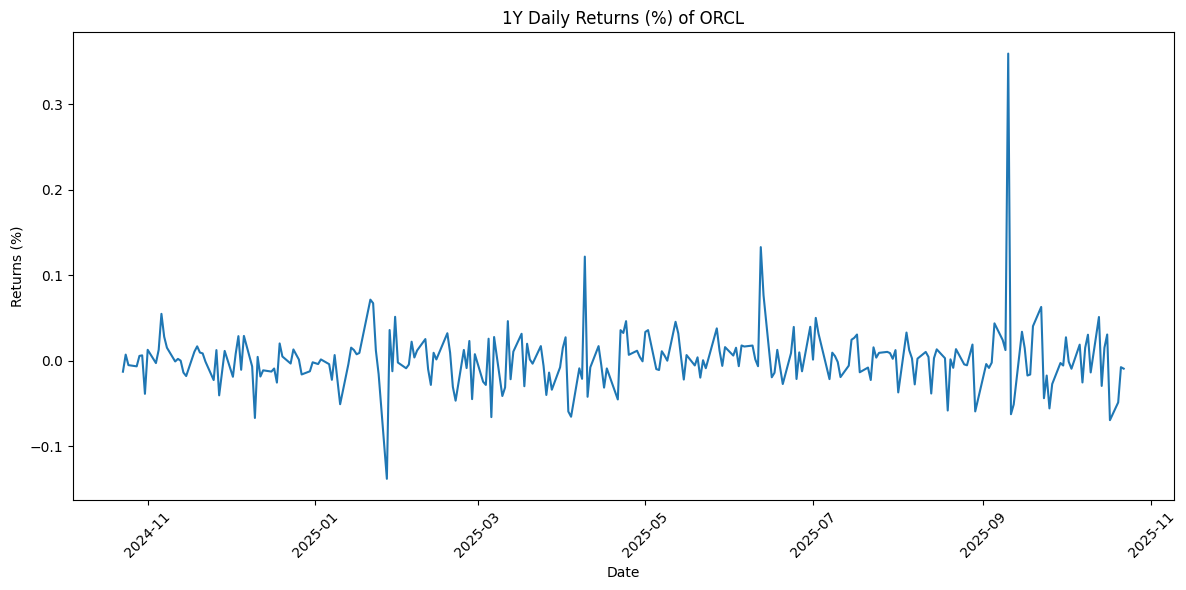

In [32]:
# Rolling
# Returns
for ticker in data_dict:
    df = data_dict[ticker]

    fig,ax = plt.subplots(figsize=(12,6))
    ax.plot(df.index, df['Rolling'])
    ax.set_title(f'1Y Daily Returns (%) of {ticker}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Returns (%)')

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()